In [1]:
import keras
import tensorflow as tf
import numpy as np
from mobilenet import *
from depthwise_conv2d import DepthwiseConv2D
import sys
sys.path.append('../CustomLayers/')
sys.path.append('../Keras/')
from TB_writer import TB_writer
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
import keras.backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from CustomOps import multibit, binarize
from multi_gpu import make_parallel

Using TensorFlow backend.


In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = train_datagen.flow_from_directory(
        '/data/imagenet/train/',
        target_size = (224, 224),
        batch_size=128,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        '/data/imagenet/val/',
        target_size = (224, 224),
        batch_size=128,
        class_mode='categorical')

Found 1281167 images belonging to 1000 classes.
Found 50000 images belonging to 1000 classes.


In [5]:
img_w = 224
img_h = 224
img_c = 3

inp = Input(shape=(img_w, img_h, img_c))

model = MobileNet(input_tensor=inp, shallow=True)

In [6]:
model.load_weights("mobilenet.h5")
#model = to_multi_gpu(model, n_gpus=3)
# make accessor to the weights
#core_model = model.layers[4]

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

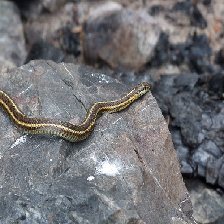

In [91]:
img = image.load_img("/data/imagenet/train/n01735189/n01735189_10181.JPEG", target_size=(img_w, img_h))
img

In [92]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255

In [96]:
preds = model.predict(x)

In [97]:
print('Predicted', decode_predictions(preds, top=3)[0])

('Predicted', [(u'n01728572', u'thunder_snake', 0.35381612), (u'n01735189', u'garter_snake', 0.16759281), (u'n01685808', u'whiptail', 0.12665948)])


In [99]:
model.layers[7].get_weights()[0]

array([-1.,  1.], dtype=float32)

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      864       
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 32)      0         
_________________________________________________________________
depthwise_conv2d_1 (Depthwis (None, 112, 112, 32)      288       
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
activation_2 (Activation)    (None, 112, 112, 32)      0         
__________

In [13]:
def binarize_layer(layer):
    #bin_weights = multibit(layer.weights[0], 32)
    bin_weights = binarize(layer.weights[0])
    bin_weights = K.get_session().run(bin_weights)
    layer.set_weights([bin_weights])
    layer.trainable = False

In [14]:
def partial_binarize(layer, fraction):
    weights = layer
    flat_weights = np.reshape(weights, (-1,))
    num_elements = flat_weights.shape[0]
    binarize_total = num_elements * fraction
    already_binarized = np.count_nonzero(np.abs(flat_weights) == 1.)
    to_binarize = int(np.ceil(binarize_total - already_binarized))
    # make a copy of the input with already binarized values set to 0 so they dont interfere
    flat_pruned = np.copy(flat_weights)
    flat_pruned[np.abs(flat_pruned) == 1] = 0
    # now find the values and the indices to binarize
    if (to_binarize > 0):
        largest_indices = (np.abs(flat_pruned)).argsort()[-to_binarize:][::1]
        truths = np.asarray(flat_pruned[largest_indices] > 0, dtype=np.float32)
        truths[truths == True] = 1.
        truths[truths == False] = -1.
        flat_weights[largest_indices] = truths
    
    output_weights = np.reshape(flat_weights, weights.shape)
    return output_weights

In [15]:
def partial_layer(layer, fraction):
    weights = K.get_session().run(layer.weights[0])
    bin_weights = partial_binarize(weights, fraction)
    layer.set_weights([bin_weights])

In [16]:
def partial_model(model, fraction):
    for layer in model.layers:
        if "conv2d" in layer.name and "depthwise" not in layer.name:          
            partial_layer(layer, fraction)

In [95]:
# retrain a little to better deal with the binarization
for i in range(3):
    partial_model(model, 1)
    model.fit_generator(
            train_generator,
            steps_per_epoch = 100,
            epochs = 1,
            validation_data = validation_generator,
            validation_steps = 50)
partial_model(model, 1)    

Epoch 1/1
100/100 [==============================] - 162s - loss: 3.1660 - acc: 0.3294 - val_loss: 5.2533 - val_acc: 0.1489
Epoch 1/1
100/100 [==============================] - 160s - loss: 2.9683 - acc: 0.3629 - val_loss: 3.9230 - val_acc: 0.2483
Epoch 1/1
100/100 [==============================] - 160s - loss: 2.8893 - acc: 0.3784 - val_loss: 3.4992 - val_acc: 0.2973
